### <center> **Análise Preditiva:** Música

**Objetivo:** Prever a música que será a mais escutada no próximo mês. Retornar também as top 5 músicas.

In [322]:
# Importações
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import warnings


In [323]:
warnings.filterwarnings('ignore')

In [324]:
# Lê o csv com o gênero das músicas
df = pd.read_csv('spotify_songs_sofia.csv')

### Compreensão dos Dados

In [325]:
df.info()
df.describe()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25997 entries, 0 to 25996
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ts                                 25997 non-null  object 
 1   platform                           25997 non-null  object 
 2   ms_played                          25997 non-null  int64  
 3   conn_country                       25997 non-null  object 
 4   ip_addr                            25997 non-null  object 
 5   master_metadata_track_name         25997 non-null  object 
 6   master_metadata_album_artist_name  25997 non-null  object 
 7   master_metadata_album_album_name   25965 non-null  object 
 8   spotify_track_uri                  25997 non-null  object 
 9   episode_name                       0 non-null      float64
 10  episode_show_name                  0 non-null      float64
 11  spotify_episode_uri                0 non-null      flo

,ts,platform,ms_played,conn_country,ip_addr,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,...,audiobook_chapter_uri,audiobook_chapter_title,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode,genero
0,2023-04-04 18:25:30+00:00,android,11451,BR,177.76.148.44,Talk that Talk,TWICE,BETWEEN 1&2,spotify:track:0RDqNCRBGrSegk16Avfzuq,NaN,...,NaN,NaN,playbtn,endplay,False,True,False,1680632717,False,k-pop
1,2023-04-04 18:25:47+00:00,android,16559,BR,177.76.148.44,There's Nothing Holdin' Me Back,Shawn Mendes,Illuminate,spotify:track:7JJmb5XwzOO8jgpou264Ml,NaN,...,NaN,NaN,playbtn,endplay,False,True,False,1680632730,False,pop
2,2023-04-04 18:25:55+00:00,android,4168,BR,177.76.148.44,Woman,Doja Cat,Planet Her,spotify:track:6Uj1ctrBOjOas8xZXGqKk4,NaN,...,NaN,NaN,playbtn,endplay,False,True,False,1680632747,False,pop
3,2023-04-04 19:23:17+00:00,android,80840,BR,177.76.148.44,FLOWER,JISOO,ME,spotify:track:69CrOS7vEHIrhC2ILyEi0s,NaN,...,NaN,NaN,clickrow,logout,False,False,False,1680635513,False,k-pop
4,2023-04-04 22:51:39+00:00,android,67760,BR,201.42.207.140,FLOWER,JISOO,ME,spotify:track:69CrOS7vEHIrhC2ILyEi0s,NaN,...,NaN,NaN,appload,logout,False,False,False,1680647986,False,k-pop


### Preparação de Dados

In [326]:
# Colunas necessárias: ts, ms_played, master_metadata_track_name, master_metadata_album_artist_name, shuffle, skipped

# Copiando os dados para outro df
df_music = df[['ts', 'ms_played', 'master_metadata_track_name', 'master_metadata_album_artist_name', 'shuffle', 'skipped']].copy()

# apagando do df as músicas que foram puladas e estavam no modo aleatório
df_music = df_music[~((df_music['shuffle'] == True) & (df_music['skipped'] == True))]

# Convertendo para timestamp
df_music['ts'] = pd.to_datetime(df['ts'])

# Criando colunas de mês
df_music['mes'] = df_music['ts'].dt.to_period('M')

# Convertendo ms_played para minutos
df_music['min_played'] = df_music['ms_played'] / 60000

# df limpo
display(df_music.head())

,ts,ms_played,master_metadata_track_name,master_metadata_album_artist_name,shuffle,skipped,mes,min_played
0,2023-04-04 18:25:30+00:00,11451,Talk that Talk,TWICE,False,True,2023-04,0.190850
1,2023-04-04 18:25:47+00:00,16559,There's Nothing Holdin' Me Back,Shawn Mendes,False,True,2023-04,0.275983
2,2023-04-04 18:25:55+00:00,4168,Woman,Doja Cat,False,True,2023-04,0.069467
3,2023-04-04 19:23:17+00:00,80840,FLOWER,JISOO,False,False,2023-04,1.347333
4,2023-04-04 22:51:39+00:00,67760,FLOWER,JISOO,False,False,2023-04,1.129333


In [327]:
# Agregação mensal por música e artista
df_month = (
    df_music.groupby(['mes', 'master_metadata_track_name', 'master_metadata_album_artist_name'])
      ['min_played'].sum()
      .reset_index()
)

df_month['mes'] = df_month['mes'].dt.to_timestamp()
df_month = df_month.sort_values('mes')

# Preenche 0 nos meses que a música não foi ouvida
todos_meses = pd.date_range(
    start=df_month['mes'].min(),
    end=df_month['mes'].max(),
    freq='MS'
)
musicas_unicas = df_month[['master_metadata_track_name', 'master_metadata_album_artist_name']].drop_duplicates()
grade_completa = musicas_unicas.merge(
    pd.DataFrame({'mes': todos_meses}), how='cross'
)

df_month = grade_completa.merge(
    df_month,
    on=['master_metadata_track_name', 'master_metadata_album_artist_name', 'mes'],
    how='left'
).fillna({'min_played': 0})

# Criando variável temporal ordinal (numerando cada mês)
min_mes = df_month['mes'].min()
df_month['mes_ord'] = (
    (df_month['mes'].dt.year - min_mes.year) * 12 +
    (df_month['mes'].dt.month - min_mes.month) + 1
)

# Próximo mês a prever
ultimo_mes_ord = df_month['mes_ord'].max()
proximo_mes_ord = ultimo_mes_ord + 1

display(df_month.head())

# Mapeamento de mes_ord para label legível (como 'Jan/2024')
mes_map = (
    df_month[['mes_ord', 'mes']]
    .drop_duplicates()
    .set_index('mes_ord')['mes']
    .apply(lambda d: d.strftime('%b/%Y'))
)


,master_metadata_track_name,master_metadata_album_artist_name,mes,min_played,mes_ord
0,34+35,Ariana Grande,2023-04-01,2.895167,1
1,34+35,Ariana Grande,2023-05-01,2.895167,2
2,34+35,Ariana Grande,2023-06-01,0.000000,3
3,34+35,Ariana Grande,2023-07-01,0.000000,4
4,34+35,Ariana Grande,2023-08-01,0.000000,5


### Modelo

In [328]:
resultados = []
avaliacoes = []

for musica in df_month['master_metadata_track_name'].unique():
    df_tmp = df_month[
        df_month['master_metadata_track_name'] == musica
    ][['mes_ord', 'min_played', 'master_metadata_album_artist_name']].copy()

    df_tmp = df_tmp.sort_values('mes_ord').dropna()

    # Pula músicas com histórico curto
    if len(df_tmp) < 3:
        continue

    artista = df_tmp['master_metadata_album_artist_name'].iloc[0]

    # Divisão de treino e teste
    n_test = 2
    train = df_tmp.iloc[:-n_test]
    test = df_tmp.iloc[-n_test:]

    X_train = train[['mes_ord']]
    y_train = train['min_played']
    X_test  = test[['mes_ord']]
    y_test  = test['min_played']

    # Modelo
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Previsão do teste
    y_pred = model.predict(X_test)

    # Avaliação
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    avaliacoes.append({'musica': musica, 'artista': artista, 'MAE': mae, 'RMSE': rmse, 'R2': r2})

    # Previsão do próximo mês
    previsao = model.predict([[proximo_mes_ord]])[0]
    previsao = max(previsao, 0) 

    resultados.append({'musica': musica, 'artista': artista,'previsao_minutos': previsao})

print(f"Modelos treinados para {len(resultados)} músicas.")

Modelos treinados para 4030 músicas.


### Resultado das Avaliações

In [329]:
df_avaliacao = pd.DataFrame(avaliacoes).sort_values('MAE')
print("10 gêneros com menor erro de previsão (MAE):")
print(df_avaliacao.head(10).to_string(index=False))

10 gêneros com menor erro de previsão (MAE):
                                          musica              artista     MAE     RMSE  R2
                          Vou Fazer um Vídeo Seu            MC Marley 0.00000 0.000000 1.0
Vira Cara pra Parede X Você Está em Paraisópolis               DJ BCH 0.00000 0.000000 1.0
                           Nós Tá Por Aí - Remix DG e Batidão Stronda 0.00000 0.000000 1.0
                                   Ai Ai Ai Bebe          Menor Teteu 0.00000 0.000000 1.0
                                            SLAY             EVERGLOW 0.00000 0.000000 1.0
                              Knife (NI-KI Ver.)              ENHYPEN 0.00000 0.000000 1.0
                                      Fact Check              NCT 127 0.00000 0.000000 1.0
                                         Kenny G                Matuê 0.00000 0.000000 1.0
                         Ponta do Pé (Vem de Ré)             DJ Ryder 0.00000 0.000000 1.0
                                           Bi

### Resultado do Modelo (Previsão)

In [330]:
df_result = pd.DataFrame(resultados, columns=['musica', 'artista', 'previsao_minutos'])
top5 = df_result.sort_values('previsao_minutos', ascending=False).head(5)

musica = top5.iloc[0]['musica']
artista = top5.iloc[0]['artista']
minutos = top5.iloc[0]['previsao_minutos']

# Calcular o label do próximo mês a partir do último mês real
ultimo_mes_real = df_month['mes'].max()
proximo_mes_real = ultimo_mes_real + pd.DateOffset(months=1)
proximo_mes_label = proximo_mes_real.strftime('%B/%Y')

print(f"Próximo mês a prever: {proximo_mes_label}")
print(f"Música prevista para o próximo mês: '{musica}' — {artista}")
print(f"Previsão de minutos: {minutos:.2f} min\n")
print("5 músicas previstas:")
print(top5.to_string(index=False))

Próximo mês a prever: February/2026
Música prevista para o próximo mês: 'Maldita festa' — Ana Laura Lopes
Previsão de minutos: 30.87 min

5 músicas previstas:
                     musica         artista  previsao_minutos
              Maldita festa Ana Laura Lopes         30.869357
                   Gabriela         KATSEYE         24.893971
Apaguei Pra Todos - Ao Vivo        Ferrugem         22.134396
             Troca de Olhar Ana Laura Lopes         21.584265
            Futuro namorado Ana Laura Lopes         20.421724


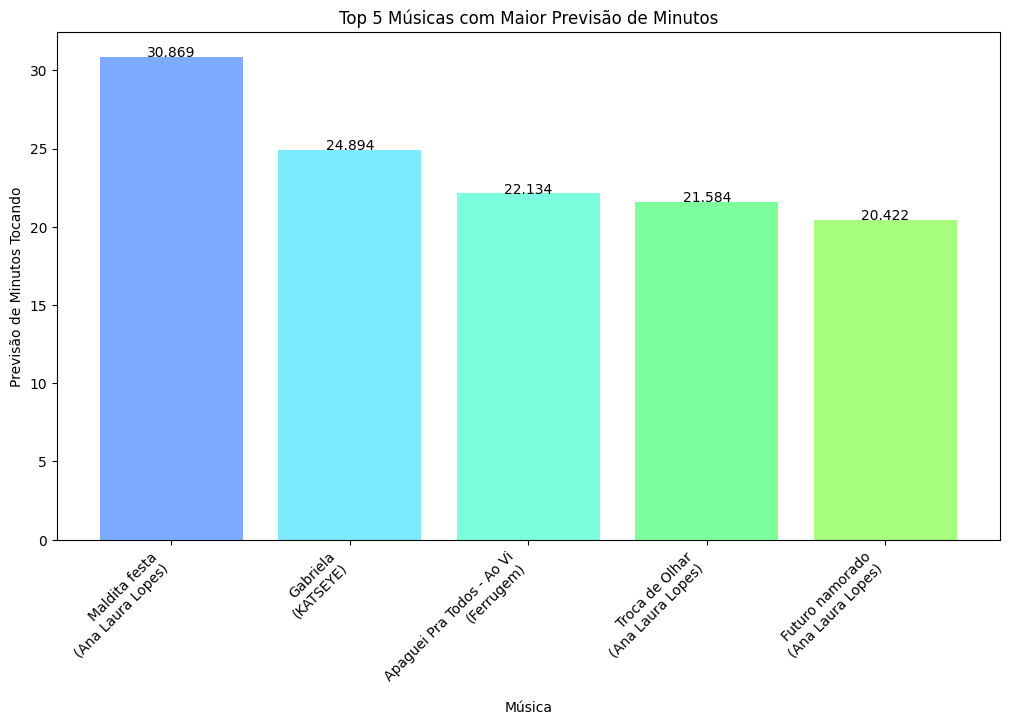

In [331]:
# Gráfico
plt.figure(figsize=(10, 6))

cores = ['#7DACFF', '#7DEBFF', '#7DFFDF', '#7DFF9E', '#A6FF7D']
labels = [f"{row['musica'][:25]}\n({row['artista'][:20]})" for _, row in top5.iterrows()]

plt.bar(labels, top5['previsao_minutos'], color=cores)
plt.title('Top 5 Músicas com Maior Previsão de Minutos')

for i, v in enumerate(top5['previsao_minutos']):
    plt.text(i, v, f"{v:.3f}", ha='center')

plt.tight_layout()

plt.xlabel('Música')
plt.ylabel('Previsão de Minutos Tocando')
plt.xticks(rotation=45, ha='right')
plt.show()

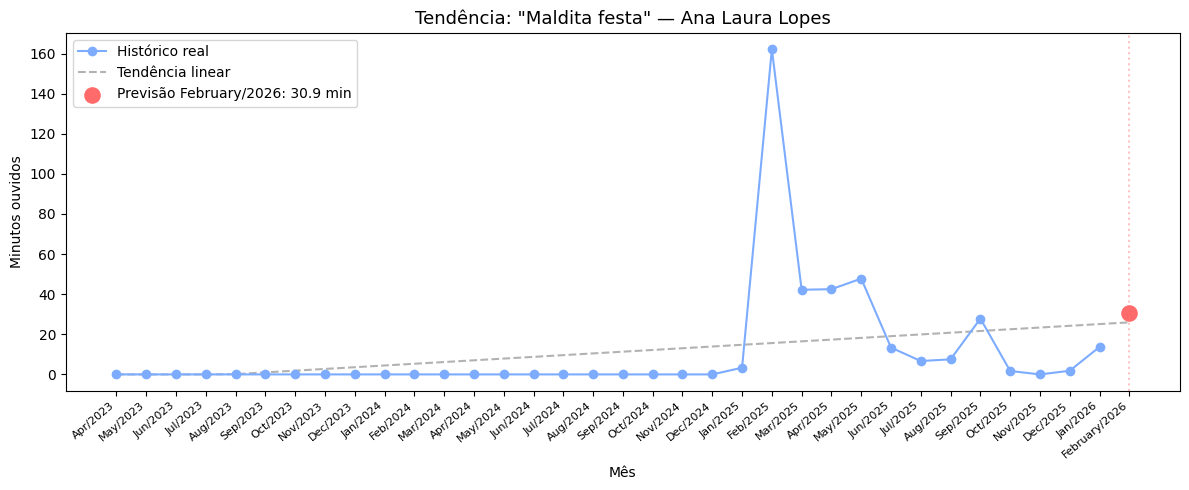

In [332]:
# Gráfico que mostra a tendência de minutos tocados do gênero previsto
df_v = (
    df_month[df_month['master_metadata_track_name'] == musica]
    [['mes_ord', 'mes', 'min_played']]
    .sort_values('mes_ord')
)

model_v = LinearRegression().fit(df_v[['mes_ord']], df_v['min_played'])

# Labels do eixo x: meses reais do histórico + próximo mês
x_ords   = list(df_v['mes_ord']) + [proximo_mes_ord]
x_labels = [mes_map.get(o, '') for o in df_v['mes_ord']] + [proximo_mes_label]

# Linha de tendência sobre todo o intervalo
x_range = np.arange(df_v['mes_ord'].min(), proximo_mes_ord + 1).reshape(-1, 1)
y_trend = np.clip(model_v.predict(x_range), 0, None)

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(df_v['mes_ord'], df_v['min_played'], 'o-', label='Histórico real', color='#7DACFF', zorder=3)
ax.plot(x_range, y_trend, '--', label='Tendência linear', color='gray', alpha=0.6)
ax.scatter([proximo_mes_ord], [minutos], color='#FF6B6B', zorder=5, s=120,
           label=f'Previsão {proximo_mes_label}: {minutos:.1f} min')

# Eixo x com meses reais
ax.set_xticks(x_ords)
ax.set_xticklabels(x_labels, rotation=40, ha='right', fontsize=8)

# Linha pontilhada vertical destacando o ponto de previsão
ax.axvline(proximo_mes_ord, color='#FF6B6B', linestyle=':', alpha=0.4)

ax.set_title(f'Tendência: "{musica}" — {artista}', fontsize=13)
ax.set_xlabel('Mês')
ax.set_ylabel('Minutos ouvidos')
ax.legend()
plt.tight_layout()
plt.show()
